# Install

In [3]:
pip install torch pykan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 9.7 MB/s eta 0:00:00


In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 23.9 MB/s eta 0:00:00


# Libraries

In [5]:
# Libraries

import torch
import numpy as np
import pandas as pd
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os

from kan import KAN
from copy import deepcopy
from kan.utils import create_dataset
from kan.utils import ex_round
from astropy.io import fits
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# Data

In [7]:
# Descargar el archivo FITS (debe ser ejecutado en la terminal)
#!wget https://dr18.sdss.org/sas/dr18/spectro/boss/redux/v6_0_4/spAll-v6_0_4.fits

In [8]:
# Loading the csv data
df = pd.read_csv('query_dr18_final.csv')

# Data
df.head()


,objid,ra,dec,u,g,r,i,z,redshift,zErr,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,class
0,1.237651e+18,145.34053,0.019135,21.00318,19.24941,18.31536,17.83355,17.48531,0.120293,0.000027,0.085621,0.022102,0.014068,0.013608,0.021289,GALAXY
1,1.237649e+18,145.25355,-0.107234,23.54388,22.24853,20.75849,19.88360,19.54911,0.484813,0.000196,0.753616,0.108991,0.043791,0.032449,0.072846,GALAXY
2,1.237649e+18,145.23331,-0.435672,21.62525,20.22280,18.83783,18.34791,18.03713,0.221124,0.000048,0.154818,0.025859,0.016046,0.014850,0.024086,GALAXY
3,1.237649e+18,145.21905,-0.186154,21.27280,19.27753,18.22260,17.80094,17.56649,0.123589,0.000033,0.110375,0.017411,0.015434,0.018130,0.023818,GALAXY
4,1.237651e+18,145.19933,-0.286225,19.45643,19.07301,19.11214,18.98963,18.96567,0.651584,0.000091,0.028871,0.015080,0.013241,0.017005,0.044520,QSO


In [9]:
# Checking for null or missing values in the data
null = df.isnull().sum().max()

if null == 0:
    print('There is no missing values')
else:
    print('There is missing values')

There is no missing values


In [10]:
# check the number of duplicates acording to objid
duplicates = df.duplicated(subset = 'objid', keep = False)

print(f"Number of duplicates: {duplicates.sum()}")


Number of duplicates: 92431


In [11]:
# Drop duplicated data according objid
df = df.drop_duplicates(subset = 'objid', keep = 'first')

print(f"Number of duplicates after drop: {df.duplicated(subset = 'objid', keep = False).sum()}")


Number of duplicates after drop: 0


In [12]:
# Data info
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 31008 entries, 0 to 99998
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   objid        31008 non-null  float64
 1   ra           31008 non-null  float64
 2   dec          31008 non-null  float64
 3   u            31008 non-null  float64
 4   g            31008 non-null  float64
 5   r            31008 non-null  float64
 6   i            31008 non-null  float64
 7   z            31008 non-null  float64
 8   redshift     31008 non-null  float64
 9   zErr         31008 non-null  float64
 10  psfMagErr_u  31008 non-null  float64
 11  psfMagErr_g  31008 non-null  float64
 12  psfMagErr_r  31008 non-null  float64
 13  psfMagErr_i  31008 non-null  float64
 14  psfMagErr_z  31008 non-null  float64
 15  class        31008 non-null  object 
dtypes: float64(15), object(1)
memory usage: 4.0+ MB


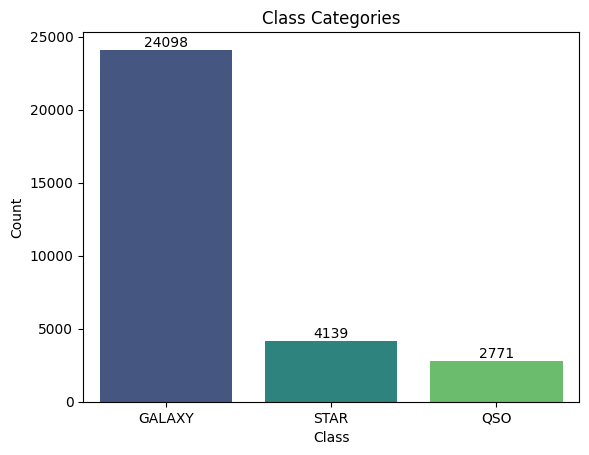

In [13]:
# Class category plot
sns.countplot(x       = df['class'],
              palette = 'viridis',
              order   = df['class'].value_counts().index
              )

plt.title('Class Categories')
plt.xlabel('Class')
plt.ylabel('Count')

# Labels for each class
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(x         = p.get_x() + p.get_width() / 2,
             y         = height,
             s         = f'{int(height)}',
             ha        = 'center',
             va        = 'bottom',
             fontsize  = 10,
             color     = 'black'
             )

plt.show()


We will be working with a total of 24098 galaxies redshifts.

In [14]:
# Filter for 'GALAXY' in 'class'
df_galaxies = df[df['class'] == 'GALAXY']

# Data visuaization
df_galaxies.head()

,objid,ra,dec,u,g,r,i,z,redshift,zErr,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,class
0,1.237651e+18,145.34053,0.019135,21.00318,19.24941,18.31536,17.83355,17.48531,0.120293,0.000027,0.085621,0.022102,0.014068,0.013608,0.021289,GALAXY
1,1.237649e+18,145.25355,-0.107234,23.54388,22.24853,20.75849,19.88360,19.54911,0.484813,0.000196,0.753616,0.108991,0.043791,0.032449,0.072846,GALAXY
2,1.237649e+18,145.23331,-0.435672,21.62525,20.22280,18.83783,18.34791,18.03713,0.221124,0.000048,0.154818,0.025859,0.016046,0.014850,0.024086,GALAXY
6,1.237651e+18,145.31208,-0.400766,23.02255,21.48124,19.87750,19.24413,18.78968,0.336823,0.000078,0.442066,0.058561,0.021522,0.021363,0.039797,GALAXY
7,1.237649e+18,145.33123,-0.542068,21.29440,20.01664,19.08634,18.73719,18.50897,0.153353,0.000018,0.114264,0.027219,0.017208,0.016414,0.032128,GALAXY


In [15]:
# Statistical summary
df_galaxies.describe()


,objid,ra,dec,u,g,r,i,z,redshift,zErr,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z
count,2.409800e+04,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000
mean,1.237657e+18,166.921263,10.943521,14.623172,12.621090,13.412854,12.177649,11.414485,0.143119,0.001381,-6.437288,-6.989552,-5.346973,-6.183681,-6.589501
std,8.380763e+12,90.103234,22.178179,258.123356,266.017726,232.623294,249.856431,258.035464,0.108373,0.090284,257.574215,265.492139,232.185871,249.394903,257.568754
min,1.237646e+18,0.019792,-9.816346,-9999.586000,-9999.457000,-9999.229000,-9999.234000,-9999.127000,-0.010875,-6.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
25%,1.237651e+18,128.525217,-0.583274,20.561615,19.077343,18.290282,17.889772,17.534060,0.075715,0.000011,0.064150,0.019823,0.015971,0.016484,0.022852
50%,1.237652e+18,175.998095,0.591986,21.120075,19.574105,18.763730,18.361535,18.006470,0.113037,0.000021,0.097367,0.023858,0.018896,0.019485,0.028645
75%,1.237663e+18,215.478510,3.173014,21.714893,20.131547,19.352027,18.964398,18.637207,0.169667,0.000034,0.162922,0.030973,0.023425,0.024072,0.040388
max,1.237680e+18,359.970790,68.739535,26.314020,25.060980,24.764470,25.382640,22.968110,0.996866,6.220311,115.515700,90.017220,150.571100,20.449130,17.780040


In [16]:
# Filters
df_galaxies = df_galaxies[df_galaxies['i'] > -9999]
df_galaxies = df_galaxies[df_galaxies['u'] > -9999]
df_galaxies = df_galaxies[df_galaxies['g'] > -9999]
df_galaxies = df_galaxies[df_galaxies['z'] > -9999]
df_galaxies = df_galaxies[df_galaxies['i'] < 22.20]
df_galaxies = df_galaxies[df_galaxies['u'] < 22.15]
df_galaxies = df_galaxies[df_galaxies['g'] < 23.13]
df_galaxies = df_galaxies[df_galaxies['z'] < 20.71]
df_galaxies = df_galaxies[df_galaxies['zErr'] < 1]
df_galaxies = df_galaxies[df_galaxies['zErr'] > -1]
df_galaxies = df_galaxies[df_galaxies['psfMagErr_z'] > -9999]
df_galaxies = df_galaxies[df_galaxies['psfMagErr_z'] < 5]
df_galaxies = df_galaxies[df_galaxies['psfMagErr_u'] < 5]
df_galaxies = df_galaxies[df_galaxies['psfMagErr_g'] < 5]
df_galaxies = df_galaxies[df_galaxies['psfMagErr_r'] < 5]
df_galaxies = df_galaxies[df_galaxies['psfMagErr_i'] < 5]
df_galaxies = df_galaxies[df_galaxies['redshift'] != 0]

# Redshift > 0
if 'redshift' in df_galaxies.columns:
    df_galaxies = df_galaxies[df_galaxies['redshift'] > 0]

# Statistical summary for the new dataset
df_galaxies.describe()


,objid,ra,dec,u,g,r,i,z,redshift,zErr,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z
count,1.987000e+04,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000,19870.000000
mean,1.237657e+18,166.277821,10.834933,20.855422,19.352607,18.609356,18.240888,17.908728,0.106413,0.000109,0.099567,0.033984,0.027248,0.027121,0.037730
std,8.398916e+12,90.605574,22.071429,0.714974,0.688649,0.729933,0.761687,0.787686,0.057799,0.005992,0.103574,0.117096,0.090439,0.069086,0.089579
min,1.237646e+18,0.019792,-9.816346,15.717210,15.260330,14.837740,14.346570,14.102270,0.000047,0.000001,0.012975,0.008393,0.007549,0.007652,0.010068
25%,1.237651e+18,126.647323,-0.580211,20.434658,18.967233,18.185962,17.787813,17.436770,0.069739,0.000010,0.058950,0.019170,0.015541,0.016018,0.021995
50%,1.237653e+18,175.285025,0.596493,20.941390,19.414215,18.608520,18.204005,17.848775,0.099431,0.000017,0.085027,0.022450,0.018081,0.018694,0.026591
75%,1.237663e+18,214.997360,3.131553,21.368670,19.811545,19.076505,18.718320,18.408288,0.136176,0.000027,0.120713,0.026624,0.021426,0.022584,0.035457
max,1.237680e+18,359.952180,68.739535,22.149790,22.245010,21.933660,21.479690,20.705860,0.972263,0.573933,3.897711,4.421279,3.563431,2.898417,4.817370


In [17]:
# Interest columns
selected_columns = [
    'objid',    # Main Id
    'u',        # U mag
    'g',        # G mag
    'r',        # R mag
    'i',        # I mag
    'z',        # Z mag
    'redshift', # Redshift
    'class',    # Class
    ]

# Target dataframe
df_KAN = df_galaxies[selected_columns]

# Data Visualization
df_KAN.head()

,objid,u,g,r,i,z,redshift,class
0,1.237651e+18,21.00318,19.24941,18.31536,17.83355,17.48531,0.120293,GALAXY
2,1.237649e+18,21.62525,20.22280,18.83783,18.34791,18.03713,0.221124,GALAXY
7,1.237649e+18,21.29440,20.01664,19.08634,18.73719,18.50897,0.153353,GALAXY
13,1.237649e+18,20.82631,19.84638,19.17397,19.05814,18.89355,0.098886,GALAXY
14,1.237651e+18,20.21383,19.05497,18.66219,18.31866,18.15481,0.061472,GALAXY


In [18]:
# New columns: u-g , g-r, r-i, i-z
df_KAN['U-G'] = df_KAN['u'] - df_KAN['g']
df_KAN['G-R'] = df_KAN['g'] - df_KAN['r']
df_KAN['R-I'] = df_KAN['r'] - df_KAN['i']
df_KAN['I-Z'] = df_KAN['i'] - df_KAN['z']
df_KAN['U-Z'] = df_KAN['u'] - df_KAN['z']

# Erase original columns
df_KAN.drop(columns = ['u', 'g', 'r', 'i', 'z'], inplace = True)

# Visualization of new dataframe
df_KAN.head()

,objid,redshift,class,U-G,G-R,R-I,I-Z,U-Z
0,1.237651e+18,0.120293,GALAXY,1.75377,0.93405,0.48181,0.34824,3.51787
2,1.237649e+18,0.221124,GALAXY,1.40245,1.38497,0.48992,0.31078,3.58812
7,1.237649e+18,0.153353,GALAXY,1.27776,0.93030,0.34915,0.22822,2.78543
13,1.237649e+18,0.098886,GALAXY,0.97993,0.67241,0.11583,0.16459,1.93276
14,1.237651e+18,0.061472,GALAXY,1.15886,0.39278,0.34353,0.16385,2.05902


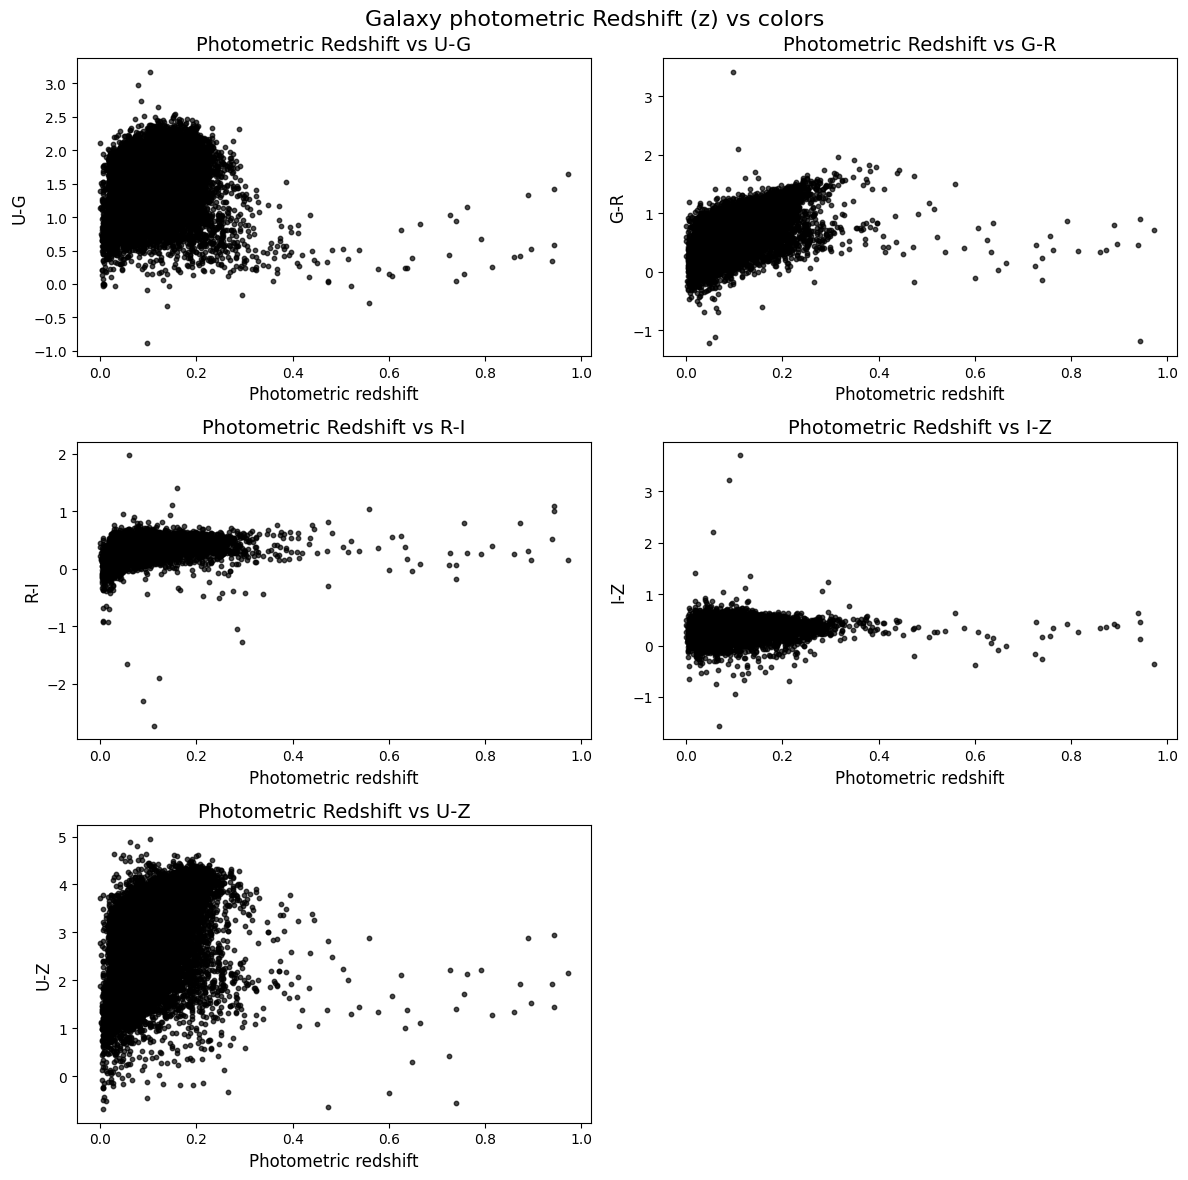

In [19]:
# Set the figure size
plt.figure(figsize = (12, 12))

# List of columns for the Y-axis
columns = ['U-G', 'G-R', 'R-I', 'I-Z', 'U-Z']

# Create subplots
for i, column in enumerate(columns):
    plt.subplot(3, 2, i + 1)  # 3 rows, 2 columns of subplots
    plt.scatter(df_KAN['redshift'], df_KAN[column], s     = 10,
                                                    alpha = 0.7,
                                                    color = 'black'
                                                    )

    # Set the title and labels for each subplot
    plt.title(f'Photometric Redshift vs {column}', fontsize = 14)
    plt.xlabel('Photometric redshift', fontsize = 12)
    plt.ylabel(column, fontsize = 12)

# Set title
plt.suptitle('Galaxy photometric Redshift (z) vs colors', fontsize = 16)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
# Verifica los nombres de las columnas
print(df_KAN.columns)

# Normalizar o estandarizar
columns_to_normalize = ['redshift',
                        'U-G',
                        'G-R',
                        'R-I',
                        'I-Z',
                        'U-Z']

# Revisa si estas columnas están en el DataFrame
missing_columns = [col for col in columns_to_normalize if col not in df_KAN.columns]
if missing_columns:
    print(f"Columnas faltantes: {missing_columns}")
else:
    # Normalizar las columnas seleccionadas
    scaler = MinMaxScaler()
    df_KAN[columns_to_normalize] = scaler.fit_transform(df_KAN[columns_to_normalize])

Index(['objid', 'redshift', 'class', 'U-G', 'G-R', 'R-I', 'I-Z', 'U-Z'], dtype='object')


In [21]:
# Visualization
df_KAN.head()

,objid,redshift,class,U-G,G-R,R-I,I-Z,U-Z
0,1.237651e+18,0.123683,GALAXY,0.650072,0.463705,0.683463,0.362797,0.744911
2,1.237649e+18,0.227395,GALAXY,0.563172,0.561139,0.685186,0.355685,0.757343
7,1.237649e+18,0.157688,GALAXY,0.532329,0.462895,0.655268,0.340010,0.615292
13,1.237649e+18,0.101664,GALAXY,0.458660,0.407171,0.605679,0.327929,0.464397
14,1.237651e+18,0.063181,GALAXY,0.502919,0.346749,0.654073,0.327789,0.486741


In [22]:
df_KAN.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19870 entries, 0 to 99998
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   objid     19870 non-null  float64
 1   redshift  19870 non-null  float64
 2   class     19870 non-null  object 
 3   U-G       19870 non-null  float64
 4   G-R       19870 non-null  float64
 5   R-I       19870 non-null  float64
 6   I-Z       19870 non-null  float64
 7   U-Z       19870 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.4+ MB


In [23]:
# Selecting interest variables and the predictor
features = ['U-G',
            'G-R',
            'R-I',
            'I-Z',
            'U-Z'
            ]

target = 'redshift'

print("Características seleccionadas:", features)
print("Variable objetivo:", target)

Características seleccionadas: ['U-G', 'G-R', 'R-I', 'I-Z', 'U-Z']
Variable objetivo: redshift


In [24]:
# Seleccionar solo las columnas numéricas
df_KAN_numeric = df_KAN[features + [target]]

# Calcular la matriz de correlación
corr_matrix = df_KAN_numeric.corr()

corr_matrix

,U-G,G-R,R-I,I-Z,U-Z,redshift
U-G,1.000000,0.679666,0.449184,0.447793,0.926488,0.102039
G-R,0.679666,1.000000,0.517865,0.316109,0.865787,0.481133
R-I,0.449184,0.517865,1.000000,0.162406,0.615314,0.340814
I-Z,0.447793,0.316109,0.162406,1.000000,0.546996,0.127007
U-Z,0.926488,0.865787,0.615314,0.546996,1.000000,0.308283
redshift,0.102039,0.481133,0.340814,0.127007,0.308283,1.000000


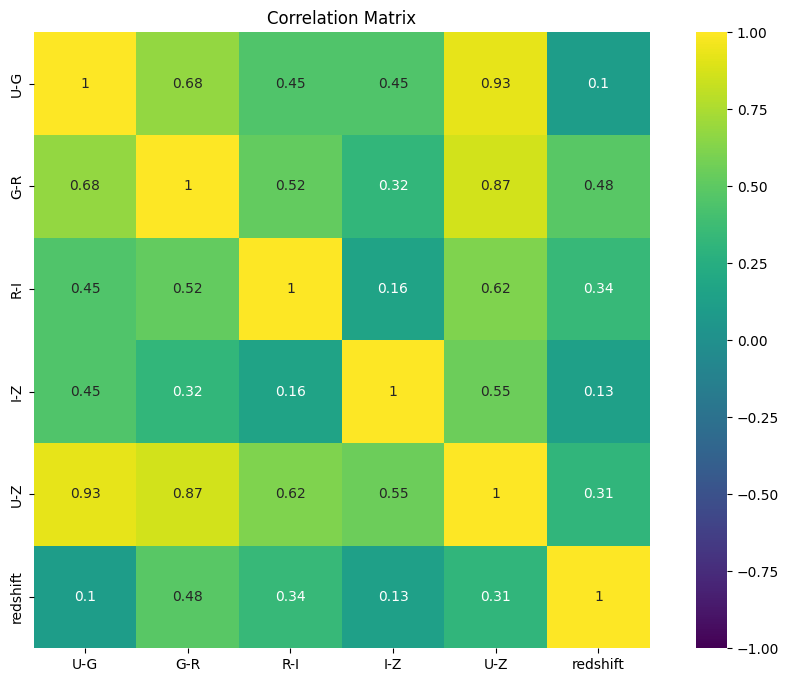

In [25]:
# Graficar la matriz de correlación
plt.figure(figsize = (12, 8))
sns.heatmap(corr_matrix, center = 0,
                         square = True,
                         vmin   = -1,
                         vmax   = 1,
                         cmap   = 'viridis',
                         annot  = True
            )

plt.title('Correlation Matrix')
plt.show()


# Split

In [26]:
# Data split
X = df_KAN[features].values
y = df_KAN[target].values


In [27]:
# Train, test and validation split
X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                    y,
                                                    test_size    = 0.2,
                                                    random_state = 42
                                                    )

X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size    = 0.5,
                                                random_state = 42
                                                )


In [28]:
# Data to PyTorch tensors
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.tensor(X_train, dtype = torch.float32, device = device)
y_train = torch.tensor(y_train, dtype = torch.float32, device = device).view(-1, 1)
X_val   = torch.tensor(X_val,   dtype = torch.float32, device = device)
y_val   = torch.tensor(y_val,   dtype = torch.float32, device = device).view(-1, 1)
X_test  = torch.tensor(X_test,  dtype = torch.float32, device = device)
y_test  = torch.tensor(y_test,  dtype = torch.float32, device = device).view(-1, 1)

In [29]:
# NaN check after the conversion
print("Valores NaN en X_train después de la conversión:")
print(torch.isnan(X_train).sum().item())
print("Valores NaN en y_train después de la conversión:")
print(torch.isnan(y_train).sum().item())

Valores NaN en X_train después de la conversión:
0
Valores NaN en y_train después de la conversión:
0


In [30]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
#test

X_train shape: torch.Size([15896, 5])
X_val shape: torch.Size([1987, 5])


In [31]:
# Data compatible with KAN
dataset = {
    'train_input': X_train,
    'train_label': y_train,
    'val_input': X_val,
    'val_label': y_val,
    'test_input': X_test,
    'test_label': y_test,
}


# KAN model 2

In [84]:
# KAN model (paper option: d, 2d+1, 1, non restrictive)
model = KAN(width  = [4,2,1],
            grid   = 3,
            k      = 3,
            seed   = 42,
            device = device
            )

# Inicial optimizaton - (optional)
#model.fit(dataset, opt          = "LBFGS", steps        = 50, lamb         = 0.002, lamb_entropy = 10.0, lamb_coef     = 1.0)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))


checkpoint directory created: ./model
saving model version 0.0
Number of trainable parameters: 120


## Training function

In [85]:
# Training function definition
def train_kan_model(model, num_epochs, criterion, optimizer, scheduler, device, print_every=1, early_stop_epochs=10):
    """
    Train the KAN model
    Args:
        model: PyTorch model (KAN)
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        device: device to train the model (CPU or GPU)
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """

    # Cache the best model
    best_model_weights = deepcopy(model.state_dict())
    best_train_loss = float('inf')
    best_valid_loss = float('inf')
    best_train_rmse = float('inf')
    best_valid_rmse = float('inf')
    best_epoch = -1

    # Initiate dictionary to record the history of loss and learning rate
    history_dic = {
        'train_loss': [],
        'valid_loss': [],
        'train_rmse': [],
        'valid_rmse': [],
        'lr': []
    }

    for epoch in range(num_epochs):
        # Start time
        epoch_start_time = time.time()

        # Train
        model.train()
        optimizer.zero_grad()

        # Forward pass
        train_preds = model(X_train.to(device))
        train_loss = criterion(train_preds, y_train.to(device))

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val.to(device))
            val_loss = criterion(val_preds, y_val.to(device))

            # Calculate RMSE for train and validation
            train_rmse = mean_squared_error(y_train.cpu(), train_preds.cpu(), squared=False)
            valid_rmse = mean_squared_error(y_val.cpu(), val_preds.cpu(), squared=False)

        # Record metrics
        history_dic['train_loss'].append(train_loss.item())
        history_dic['valid_loss'].append(val_loss.item())
        history_dic['train_rmse'].append(train_rmse)
        history_dic['valid_rmse'].append(valid_rmse)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # Check if this is the best model so far
        if val_loss < best_valid_loss:
            best_train_loss = train_loss.item()
            best_valid_loss = val_loss.item()
            best_train_rmse = train_rmse
            best_valid_rmse = valid_rmse
            best_epoch = epoch + 1

            # Update the best model weights
            best_model_weights = deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_kan_model.pth")

        # Print metrics for the current epoch
        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        mm, ss = divmod(epoch_time_used, 60)

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}\t"
                  f"Train loss: {train_loss:.4f}\t"
                  f"Train RMSE: {train_rmse:.4f}\t"
                  f"Valid loss: {val_loss:.4f}\t"
                  f"Valid RMSE: {valid_rmse:.4f}\t"
                  f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}\t"
                  f"Time: {int(mm)}m {int(ss)}s" +
                  (" <--" if epoch == (best_epoch - 1) else ""))

        # Early stopping condition
        if (epoch + 1) - best_epoch >= early_stop_epochs:
            print(f"Early stopping... (Model did not improve after {early_stop_epochs} epochs)")
            break

        # Step the scheduler with validation loss
        scheduler.step(val_loss)

    # Load the best weights into the model
    model.load_state_dict(best_model_weights)
    print(f"Best epoch = {best_epoch}, with training loss = {best_train_loss:.4f}, "
          f"training RMSE = {best_train_rmse:.4f}, validation loss = {best_valid_loss:.4f}, "
          f"and validation RMSE = {best_valid_rmse:.4f}")

    return model, history_dic




## Running the model

In [90]:
# Hyperparameters
LR            = 1e-3
STEP_SIZE     = 1
GAMMA         = 0.3
MAX_EPOCH     = 2000
EARLY_STOP    = 30

In [91]:
# Nombre del modelo y directorio de datasets
model_name = 'kan_redshift_model'
datasets_dir = '/content'  # Directorio para guardar el modelo y los resultados

# CPU o GPU config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = model.to(device)

# Función de pérdida (criterio) MSELoss (regression)
criterion = nn.MSELoss()

# Optimizador AdamW
optimizer = optim.AdamW(model.parameters(), lr = LR)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode     = 'min',
                                                            factor   = 0.3,
                                                            patience = 5,
                                                            verbose  = True
                                                 )

# Entrenar el modelo y devolver el mejor modelo
model, history_dic = train_kan_model(model,
                                     num_epochs        = MAX_EPOCH,
                                     criterion         = criterion,
                                     optimizer         = optimizer,
                                     scheduler         = scheduler,
                                     device            = device,
                                     print_every       = 1,
                                     early_stop_epochs = EARLY_STOP
                                     )

# Guardar los mejores pesos del modelo
torch.save(model.state_dict(), model_name + '.pth')
torch.save(model.state_dict(), os.path.join(datasets_dir, model_name + '.pth'))

# Convertir el historial en un DataFrame
history_df = pd.DataFrame(history_dic)

# Guardar el historial
history_df.to_csv(model_name + '_history.csv', index = False)
history_df.to_csv(os.path.join(datasets_dir, model_name + '_history.csv'), index = False)



Epoch 1/2000	Train loss: 0.0038	Train RMSE: 0.0613	Valid loss: 0.0040	Valid RMSE: 0.0633	Learning Rate: 0.001000	Time: 0m 0s <--
Epoch 2/2000	Train loss: 0.0037	Train RMSE: 0.0612	Valid loss: 0.0040	Valid RMSE: 0.0632	Learning Rate: 0.001000	Time: 0m 0s <--
Epoch 3/2000	Train loss: 0.0037	Train RMSE: 0.0611	Valid loss: 0.0040	Valid RMSE: 0.0631	Learning Rate: 0.001000	Time: 0m 0s <--
Epoch 4/2000	Train loss: 0.0037	Train RMSE: 0.0610	Valid loss: 0.0040	Valid RMSE: 0.0631	Learning Rate: 0.001000	Time: 0m 0s <--
Epoch 5/2000	Train loss: 0.0037	Train RMSE: 0.0609	Valid loss: 0.0040	Valid RMSE: 0.0630	Learning Rate: 0.001000	Time: 0m 0s <--
Epoch 6/2000	Train loss: 0.0037	Train RMSE: 0.0609	Valid loss: 0.0040	Valid RMSE: 0.0629	Learning Rate: 0.001000	Time: 0m 0s <--
Epoch 7/2000	Train loss: 0.0037	Train RMSE: 0.0608	Valid loss: 0.0039	Valid RMSE: 0.0628	Learning Rate: 0.001000	Time: 0m 0s <--
Epoch 8/2000	Train loss: 0.0037	Train RMSE: 0.0607	Valid loss: 0.0039	Valid RMSE: 0.0628	Learning

## Visualizations

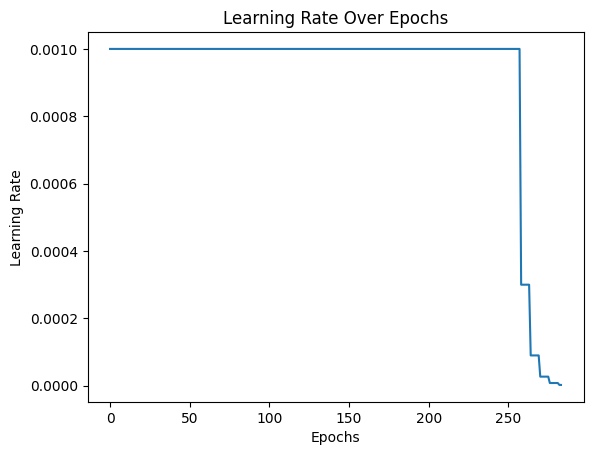

In [92]:
import matplotlib.pyplot as plt

plt.plot(history_dic['lr'])
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()


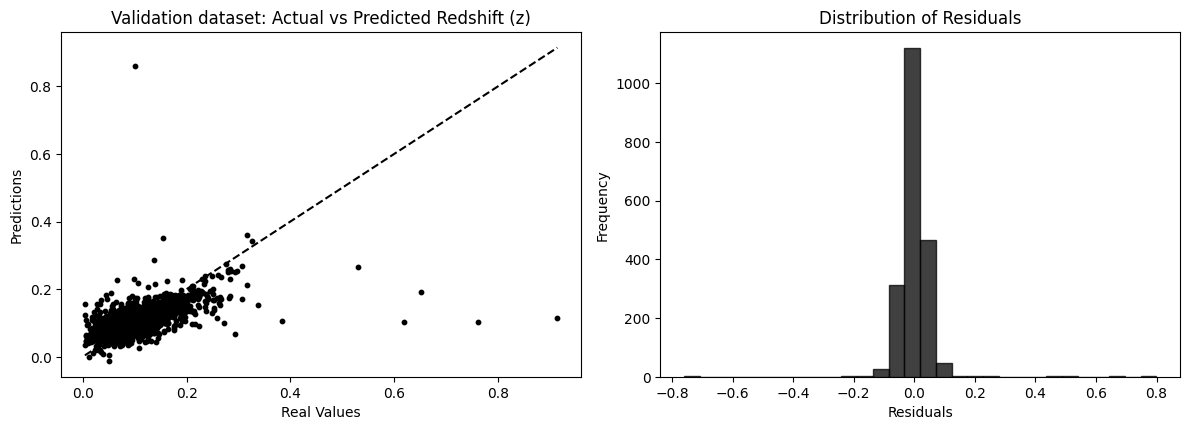

In [93]:
# Visualizing the results
plt.figure(figsize = (12, 8))

# Train loss visualization
#plt.subplot(2, 2, 1)
#plt.plot(train_loss, label = 'Pérdida de Entrenamiento')
#plt.plot(val_loss, label   = 'Pérdida de Validación')
#plt.xlabel('Paso de Entrenamiento')
#plt.ylabel('Pérdida MSE')
#plt.title('Progreso de la Pérdida Durante el Entrenamiento')
#plt.legend()


# Predictions VS real values (in the validation set)
plt.subplot(2, 2, 1)
y_val_pred = model(dataset['val_input']).detach().cpu().numpy()
y_val_cpu  = y_val.cpu().numpy()  # Mover y_val a la CPU y convertirlo a NumPy
plt.scatter(y_val_cpu, y_val_pred, s     = 10,
                                     color = 'black'
                                     )
# Add a diagonal line representing perfect predictions
plt.plot([y_val_cpu.min(), y_val_cpu.max()], [y_val_cpu.min(), y_val_cpu.max()], 'k--')

plt.xlabel("Real Values")
plt.ylabel("Predictions")
plt.title("Validation dataset: Actual vs Predicted Redshift (z)")

# Residuals
plt.subplot(2, 2, 2)
residuals = y_val_cpu - y_val_pred
plt.hist(residuals, bins    = 30,
                    alpha   = 0.75,
                    color   = 'black',
                    edgecolor = 'black'
                    )

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()


## Simbolic Function

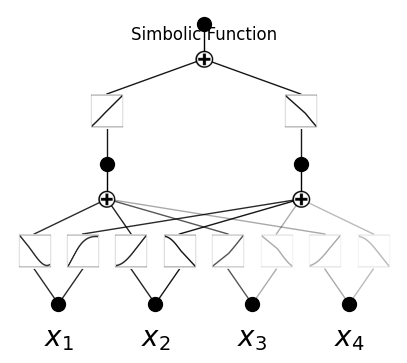

In [94]:
# Simbolic function visualization
model.plot(in_vars = [r'$x_{}$'.format(i) for i in range(1,5)])
plt.title('Simbolic Function')
plt.show()

## Evaluation metrics

In [95]:
# Test data R²
y_test_pred = model(dataset['test_input']).detach().cpu().numpy()
test_r2     = r2_score(y_test.cpu(), y_test_pred)
print(f"R² in test data: {test_r2:.4f}")

# Validation data R²
r2 = r2_score(y_val.cpu().numpy(), y_val_pred)
print(f"R² en el conjunto de validación: {r2:.4f}")


R² in test data: 0.4878
R² en el conjunto de validación: 0.3332


## Pruning

In [96]:
model = model.prune(edge_th = 5e-2)
model.auto_symbolic()

saving model version 0.1
fixing (0,0,0) with cos, r2=0.9998278021812439, c=2
fixing (0,0,1) with x^2, r2=0.9979169964790344, c=2
fixing (0,1,0) with cos, r2=0.999979555606842, c=2
fixing (0,1,1) with sin, r2=0.9999618530273438, c=2
fixing (0,2,0) with sin, r2=0.9999756813049316, c=2
fixing (0,2,1) with sin, r2=0.9997308254241943, c=2
fixing (0,3,0) with x^2, r2=0.9998461604118347, c=2
fixing (0,3,1) with x^2, r2=0.9998188018798828, c=2
fixing (1,0,0) with x, r2=0.9996275901794434, c=1
fixing (1,1,0) with x, r2=0.9999231100082397, c=1
saving model version 0.2


## New simbolic function

In [97]:
#
ex_round(model.symbolic_formula()[0][0], 3)

0.346*(0.094 - x_4)**2 + 0.342*(0.138 - x_4)**2 + 0.492*(0.714 - x_1)**2 + 0.169*sin(2.89*x_2 - 8.229) + 0.163*sin(2.646*x_3 - 1.832) + 0.035*sin(6.016*x_3 - 3.408) - 0.059*cos(4.12*x_1 - 9.343) - 0.194*cos(2.365*x_2 + 5.963) + 0.352

In [98]:
from sympy import *
ex_round(expand(ex_round(model.symbolic_formula()[0][0],4)),2)

0.49*x_1**2 - 0.7*x_1 + 0.69*x_4**2 - 0.16*x_4 + 0.17*sin(2.89*x_2 - 8.23) + 0.16*sin(2.65*x_3 - 1.83) + 0.04*sin(6.02*x_3 - 3.41) - 0.06*cos(4.12*x_1 - 9.34) - 0.19*cos(2.36*x_2 + 5.96) + 0.61

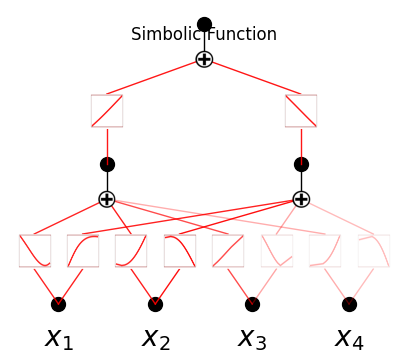

In [99]:
# Simbolic function visualization
model.plot(in_vars = [r'$x_{}$'.format(i) for i in range(1,5)])
plt.title('Simbolic Function')
plt.show()

In [100]:
# Test data R²
y_test_pred = model(dataset['test_input']).detach().cpu().numpy()
test_r2     = r2_score(y_test.cpu(), y_test_pred)
print(f"R² in test data: {test_r2:.4f}")

# Validation data R²
r2 = r2_score(y_val.cpu().numpy(), y_val_pred)
print(f"R² en el conjunto de validación: {r2:.4f}")

R² in test data: 0.4890
R² en el conjunto de validación: 0.3332


**Consistency!!!!!!**